<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/master/DCGAN_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network Example

Build a deep convolutional generative adversarial network (DCGAN) to generate digit images from a noise distribution with TensorFlow v2.


* Rewrite with editing of Example in python3.7, TF2.3 https://github.com/aymericdamien/TensorFlow-Examples/
* By Mohammed Abu Amira

## DCGAN Overview

<img src="https://jrmerwin.github.io/deeplearning4j-docs/img/GANs.png" alt="ae" style="width: 800px;"/>

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
lr_generator = 0.0002
lr_discriminator = 0.0002
training_steps = 20000
batch_size = 128
display_step = 500

# Network parameters.
noise_dim = 100 # Noise data points.

In [3]:

# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [5]:
# Create TF Model.

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.

class Generator(Model):
  # Set layers
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = layers.Dense(7 * 7 * 128)
    self.bn1 = layers.BatchNormalization()
    self.conv2tr1 = layers.Conv2DTranspose(64, 5, strides=2, padding='SAME')
    self.bn2 = layers.BatchNormalization()
    self.conv2tr2 = layers.Conv2DTranspose(1, 5, strides=2, padding='SAME')

  # Set forward pass
  def call(self, x, is_training = False):
    x = self.fc1(x)
    x = self.bn1(x, training = is_training)
    x = tf.nn.leaky_relu(x)

    # Reshape to a 4-D array of images: (batch, height, width, channels)
    # New shape: (batch, 7, 7, 128)
    x = tf.reshape(x, shape=[-1, 7,7,128])

    # Deconvolution, image shape: (batch, 14, 14, 64)
    x = self.conv2tr1(x)
    x = self.bn2(x, training = is_training)
    x = tf.nn.leaky_relu(x)

    # Deconvolution, image shape: (batch, 28, 28, 1)
    x = self.conv2tr2(x)
    x = tf.nn.tanh(x)
    return x



In [6]:
class Discriminator(Model):
  # Set Laysers
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = layers.Conv2D(64, 5, strides=2, padding='SAME')
    self.bn1 = layers.BatchNormalization()

    self.conv2 = layers.Conv2D(128, 5, strides=2, padding='SAME')
    self.bn2 = layers.BatchNormalization()

    self.flatten = layers.Flatten()

    self.fc1 = layers.Dense(1024)
    self.bn3 = layers.BatchNormalization()
    self.fc2 = layers.Dense(2)

  # Set forward pass
  def call(self, x, is_training=False):
    x = tf.reshape(x, [-1, 28, 28, 1])
    x = self.conv1(x)
    x = self.bn1(x, training=is_training)
    x = tf.nn.leaky_relu(x)

    x = self.conv2(x)
    x = self.bn2(x, training=is_training)
    x = tf.nn.leaky_relu(x)

    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn3(x, training=is_training)
    x = tf.nn.leaky_relu(x)

    x = self.fc2(x)
    return x

In [7]:
# Build Neural Network model 
generator = Generator()
discriminator = Discriminator()

In [8]:
# Define generator_loss function
def generator_loss(reconstructed_image):
  gen_loss = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=reconstructed_image, 
          labels=tf.ones([batch_size], dtype=tf.int32)))
  return gen_loss

In [9]:
# Define discriminator_loss function
def discriminator_loss(disc_fake, disc_real):
  disc_loss_real = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits = disc_real,
          labels = tf.ones([batch_size], dtype=tf.int32)))
  
  disc_loss_fake = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits = disc_fake,
          labels = tf.zeros([batch_size], dtype=tf.int32)))
  
  return disc_loss_real + disc_loss_fake

In [10]:
# optimizers 
optimizers_gen = tf.optimizers.Adam(learning_rate=lr_generator)
optimizers_disc = tf.optimizers.Adam(learning_rate=lr_discriminator)

In [11]:
# Optimization process. Inputs: real image and noise.

def rnu_optimization(real_images):
  # Rescale to [-1, 1], the input range of the discriminator
  real_images = real_images * 2. -1.

  # Generate noise.
  noise = np.random.normal(-1., 1., size = [batch_size, noise_dim]).astype(np.float32)

  with tf.GradientTape() as tap:

    fake_images = generator(noise, is_training=True)
    disc_fake = discriminator(fake_images, is_training=True)
    disc_real = discriminator(real_images, is_training=True)

    disc_loss = discriminator_loss(disc_fake, disc_real)

  # Training Variables for each optimizer
  gradients_disc = tap.gradient(disc_loss, discriminator.trainable_variables)
  optimizers_disc.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))


  # Generate noise.
  noise = np.random.normal(-1., 1., size = [batch_size, noise_dim]).astype(np.float32)

  with tf.GradientTape() as tap:

    fake_images = generator(noise, is_training=True)
    disc_fake = discriminator(fake_images, is_training=True)

    gen_loss = generator_loss(disc_fake)

  # Training Variables for each optimizer
  gradients_gen = tap.gradient(gen_loss, generator.trainable_variables)
  optimizers_gen.apply_gradients(zip(gradients_gen, generator.trainable_variables))


  return gen_loss, disc_loss

In [12]:
def plot_loss(step, gen_loss, disc_loss):

  fig, ax = plt.subplots()
  ax.plot(gen_loss, label = 'Generator loss')
  ax.plot(disc_loss, label = 'Discriminator loss')

  ax.legend(loc='upper left', shadow=True)
  ax.grid(False)
  ax.set_xlabel('Steps') 
  ax.set_ylabel('Loss')
  ax.set_title("Lossess")


gen_loss_, disc_loss_ = [], []

In [13]:
# Run training for the given number of steps.

for step, (batch_x, _) in enumerate(train_data.take(training_steps+1)):
  if step == 0:
    # Generate noise
    noise = np.random.normal(-1., 1., size = [batch_size, noise_dim]).astype(np.float32)

    disc_ = discriminator(generator(noise))
    gen_loss = generator_loss(disc_)

    disc_img = discriminator(batch_x)
    disc__ = discriminator(generator(noise))
    disc_loss = discriminator_loss(disc_img, disc__)

    print("initial: gen_loss: %f, disc_loss: %f" % (gen_loss, disc_loss))
    continue

  # Run Optimization
  gen_loss, disc_loss = rnu_optimization(batch_x)
  


  if step % display_step == 0:
    print("step: %i, gen_loss: %f, disc_loss: %f" % (step, gen_loss, disc_loss))
    gen_loss_.append(gen_loss)
    disc_loss_ .append(disc_loss)



initial: gen_loss: 0.695287, disc_loss: 1.375123
step: 500, gen_loss: 1.842255, disc_loss: 0.439439
step: 1000, gen_loss: 1.889248, disc_loss: 0.587449
step: 1500, gen_loss: 2.185499, disc_loss: 0.401658
step: 2000, gen_loss: 2.320690, disc_loss: 0.303938
step: 2500, gen_loss: 2.695751, disc_loss: 0.241700
step: 3000, gen_loss: 2.613542, disc_loss: 0.368307
step: 3500, gen_loss: 3.502686, disc_loss: 0.226699
step: 4000, gen_loss: 3.611244, disc_loss: 0.362537
step: 4500, gen_loss: 3.243215, disc_loss: 0.170885
step: 5000, gen_loss: 4.310982, disc_loss: 0.156764
step: 5500, gen_loss: 3.671767, disc_loss: 0.138449
step: 6000, gen_loss: 4.569909, disc_loss: 0.175878
step: 6500, gen_loss: 3.951028, disc_loss: 0.130504
step: 7000, gen_loss: 5.504345, disc_loss: 0.087682
step: 7500, gen_loss: 3.938004, disc_loss: 0.132368
step: 8000, gen_loss: 5.768081, disc_loss: 0.114317
step: 8500, gen_loss: 4.480205, disc_loss: 0.152486
step: 9000, gen_loss: 5.725984, disc_loss: 0.107663
step: 9500, gen_

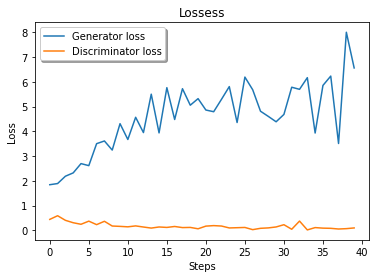

In [14]:
plot_loss(step, gen_loss_, disc_loss_)
plt.show()

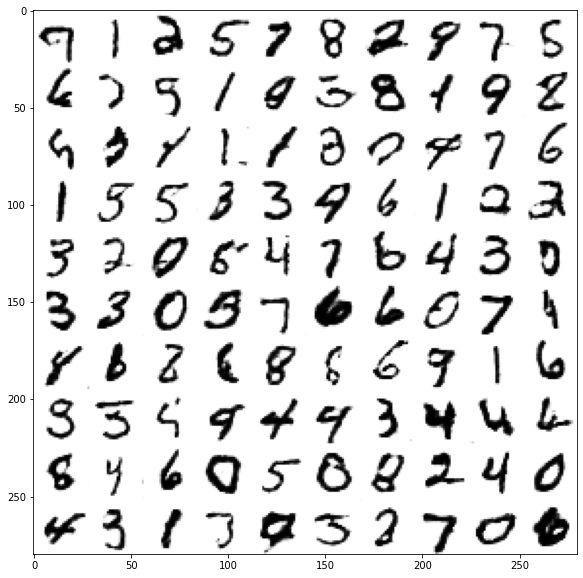

In [15]:
# Testing
# Generate images from noise, using the generator network.
n = 10
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.normal(-1., 1., size=[n, noise_dim]).astype(np.float32)
    # Generate image from noise.
    g = generator(z).numpy()
    # Rescale to original [0, 1]
    g = (g + 1.) / 2
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()